In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os

from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries

from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import flatten_list

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif, cross, dot

from desc.optimize import lsqtr, lsq_auglag

from desc.magnetic_fields import FourierCurrentPotentialField

import time

import numpy as np
from numpy import ndarray

from desc.fns_simp import (plot_figure,
                           plot_figure2,
                            plot_xy,
                           surf_int,
                           _compute_magnetic_field_from_Current)

from find_sour import iso_coords_interp, bn_res, B_sour, K_sour, densify_linspace, alt_grid

DESC version 0.12.3+556.g39aa21e25.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100-SXM4-80GB (id=0), with 80.00 GB available memory

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

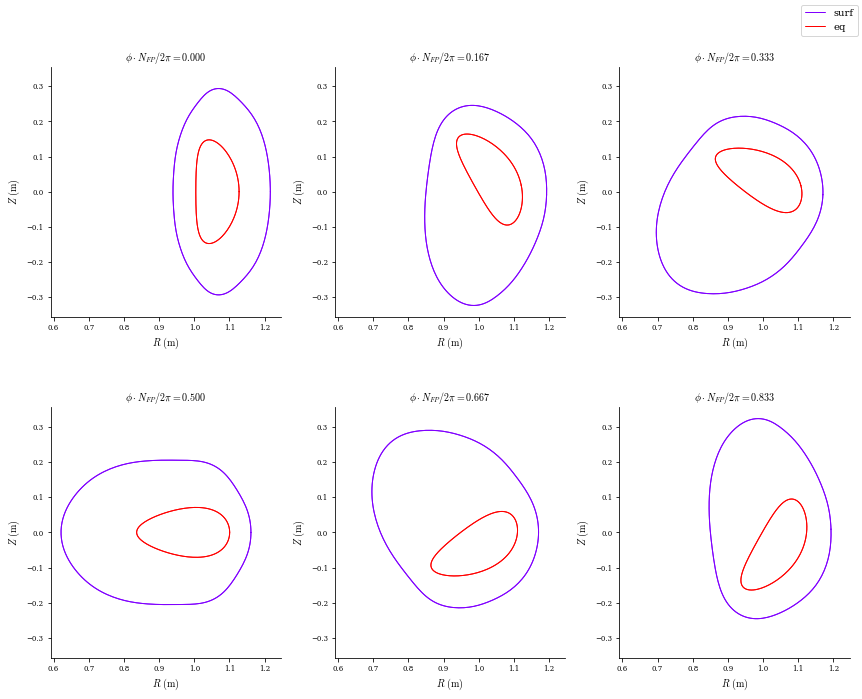

In [3]:
# Plasma surfaces
#eqname_QA = "/scratch/gpfs/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eqname_QA = "input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eq = eq_QA

name = 'iso_coords/'
# Winding surface
surf_winding = load(name + "surf.h5")

# Plot both surfaces
plot_comparison([surf_winding,eq],labels=["surf","eq"],theta=0,rho=np.array(1.0))

In [4]:
# Evaluate Green's function for flat tori
sgrid = LinearGrid(M = 100, N = 100,
                   NFP = surf_winding.NFP,
                  )
sdata = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s"], grid = sgrid)
sdata = iso_coords_interp(name, sdata, sgrid, surf_winding)

G = np.load(name + "G.npy")
K_sec = G * cross(sdata["n_rho"], sdata["e^u_s"])
K_sv = surf_winding.compute(["K"],grid = sgrid)["K"]

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

In [5]:
sgrid2 = Grid(nodes = jnp.vstack((sgrid.nodes[:,0],
                                        sgrid.nodes[:,1],
                                        sgrid.nodes[:,2] + (2*np.pi/surf_winding.NFP)*1)).T
                    )
sgrid3 = Grid(nodes = jnp.vstack((sgrid.nodes[:,0],
                                        sgrid.nodes[:,1],
                                        sgrid.nodes[:,2] + (2*np.pi/surf_winding.NFP)*2)).T
                    )

sdata2 = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s"], grid = sgrid2)
sdata2 = iso_coords_interp(name, sdata2, sgrid2, surf_winding)

sdata3 = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s"], grid = sgrid3)
sdata3 = iso_coords_interp(name, sdata3, sgrid3, surf_winding)

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

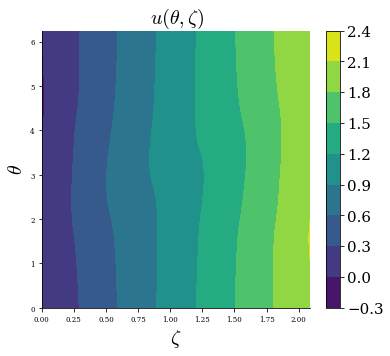

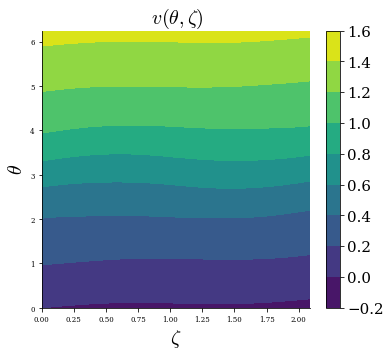

In [6]:
# Confirm that variables have the same shape
plot_figure2(sdata["u_iso"],sgrid,''r' $ u(\theta,\zeta)$ ')
plot_figure2(sdata["v_iso"],sgrid,''r' $ v(\theta,\zeta)$ ')
#plot_figure2(sdata["lambda_iso"],sgrid,''r' $ \lambda $ ')

#plot_figure2(sdata2["u_iso"],sgrid2,''r' $ u(\theta,\zeta)$ ')
#plot_figure2(sdata2["v_iso"],sgrid2,''r' $ v(\theta,\zeta)$ ')

#plot_figure2(sdata3["u_iso"],sgrid3,''r' $ u(\theta,\zeta)$ ')
#plot_figure2(sdata3["v_iso"],sgrid3,''r' $ v(\theta,\zeta)$ ')

In [7]:
eps = 1e-2
dt = eps
dz = eps
d0 = eps/3

In [8]:
grid_M = 40
grid_N = 40

In [9]:
egrid = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
edata = eq.compute(["n_rho","B"], grid = egrid)

#B_s = edata["B"]
B_sec = np.load('iso_coords/B_sec_'+str(grid_M)+'x'+str(grid_N)+'.npy')
#_compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid, basis = "rpz" )
B_s = _compute_magnetic_field_from_Current( sgrid, K_sv, surf_winding, eq, egrid, basis = "rpz" )
#B_s = _compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid, basis = "rpz" )
rhs = jnp.concatenate((B_s[:,0],B_s[:,1],B_s[:,2],
                      jnp.asarray([0])))
#- dot( edata["n_rho"],  B_sec )

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

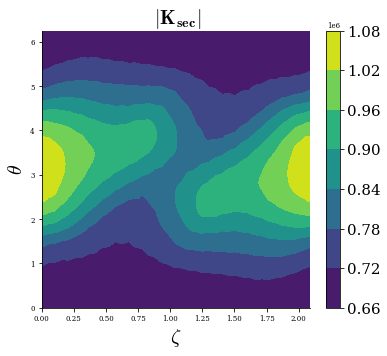

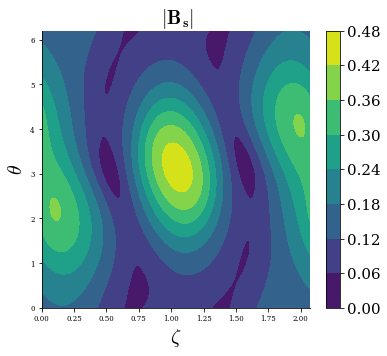

In [10]:
plot_figure2( dot(K_sec,K_sec) ** (1/2), sgrid,''r' $ | \mathbf{K_{sec}} |$ ')
plot_figure2( dot(B_s,B_s) ** (1/2), egrid,''r' $ | \mathbf{B_{s}} |$ ')
#plot_figure2( rhs, egrid, ''r' $ \mathbf{B_{sec} \cdot n}$ ' )

In [11]:
N = 20 # Terms toa pproximate the infinite series

# Numer of dipoles
sMv = np.asarray([30,]) # Poloidal direction
sNv = np.asarray([30,]) # Toroidal direction

b_chi = [] # Store the integral of the error 
source_chi = [] # Store the sum of sinks and sources of current
Bn_chi = [] # Store the max Bn from the solution
max_I = [] # Store the max value of sources
min_I = [] # Store the min value of sources

In [12]:
grid_M2 = grid_M
grid_N2 = grid_N

egrid2 = LinearGrid(M = grid_M2, N = grid_N2, NFP = eq.NFP)
edata2 = eq.compute(["n_rho"], grid = egrid2)

B_sec2 = np.load('iso_coords/B_sec_'+str(grid_M2)+'x'+str(grid_N2)+'.npy')
#_compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid2, basis = "rpz" )
B_s2 = _compute_magnetic_field_from_Current( sgrid, K_sv, surf_winding, eq, egrid2, basis = "rpz" )
#B_s2 = edata2["B"]

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

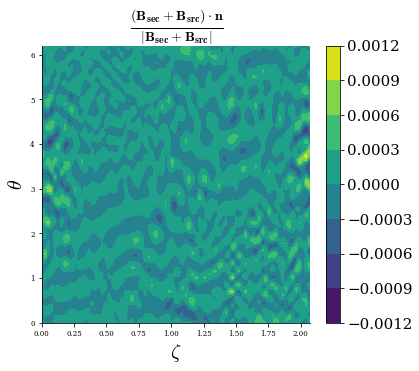

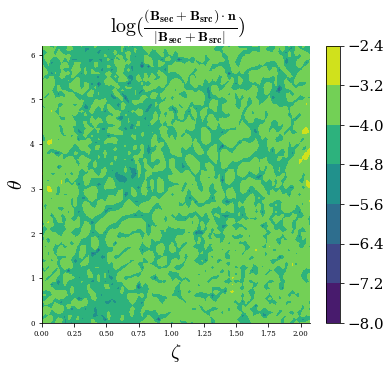

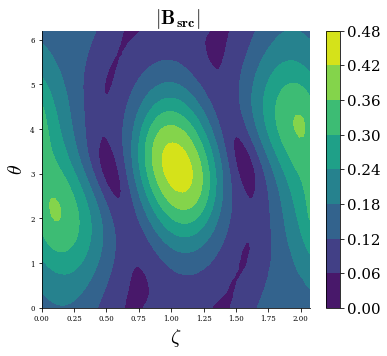

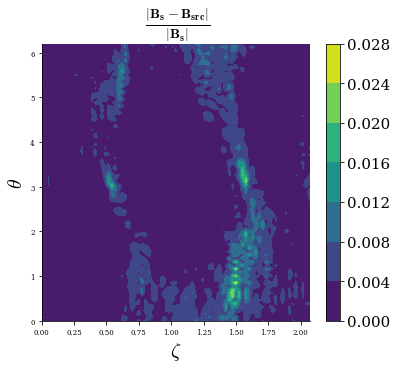

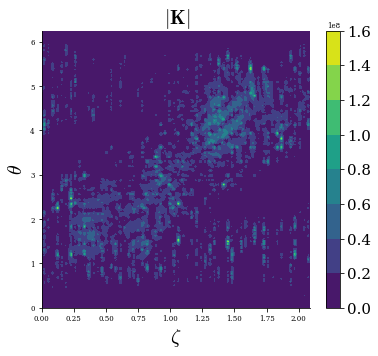

In [13]:
for i in range(0,len(sMv)):

    p_M = sMv[i]
    p_N = sNv[i]

    x = jnp.ones( ( p_M * 2 + 0 ) * ( p_N * 2 + 0 )  + 0)
    
    fun_wrapped1 = lambda x: bn_res(p_M, p_N, # Dipole pairs in toroidal direction 
                                    sdata,
                                    sdata2,
                                    sdata3,
                                    sgrid, surf_winding, 
                                    x, 
                                    N, d0,
                                    eq, egrid)

    #wrapped_jit = jit(fun_wrapped1)
    #wrapped_jit(x)
    A = Derivative(fun_wrapped1, deriv_mode="looped").compute(x)
    
    #alpha = 1e-20
    #A_inv, _ = svd_inv_null( A.T @ A + alpha * jnp.eye( A.shape[1] ) )
    
    # Find the regularized solution of dipoles
    #soln = A_inv @ ( rhs @ A)
    soln = jnp.linalg.pinv(A) @ rhs

    test = A@soln
    tsize = edata['n_rho'].shape[0]
    B_d2 = jnp.column_stack((test[0:tsize],test[tsize:tsize*2],test[tsize*2:tsize*3]))
    
    #B_sour(p_M, p_N,
    #             sdata, sgrid, surf_winding, #winding_surf,
    #             soln,
    #             N, d0,
    #             eq, egrid2)
    
    K_d = K_sour(p_M, p_N,
                 sdata,
                 sdata2,
                 sdata3,
                 sgrid,
                 surf_winding, 
                 #winding_surf,
                 soln,
                 N, d0)
    
    B0 = B_d2 - B_s2
    B_total = B_d2 + B_sec2
    Bn_total = dot(edata2["n_rho"],B_total)
    K0 = K_d
    
    #res = A @ soln - rhs
    
    #plot_figure2( res, egrid, ''r' $ \mathbf{B \cdot n}$ ' )
    plot_figure2( Bn_total * dot(B_total,B_total)**(-1/2), egrid2,
                 ''r' $ \frac{ (\mathbf{B_{sec} + B_{src}}) \cdot \mathbf{n} }{| \mathbf{B_{sec} + B_{src}} | }$ ' )
    plot_figure2( jnp.log10(abs(Bn_total * dot(B_total,B_total)**(-1/2))), egrid2,
                 ''r' $ \log( \frac{ (\mathbf{B_{sec} + B_{src}}) \cdot \mathbf{n} }{| \mathbf{B_{sec} + B_{src}} | })$ ' )

    
    plot_figure2( dot(B_d2,B_d2)**(1/2), egrid2, ''r' $ | \mathbf{B_{src}}  | $ ' )
    plot_figure2( dot(B0,B0)**(1/2) * dot(B_s2,B_s2)**(-1/2), 
                 egrid2, 
                 ''r' $ \frac{| \mathbf{B_s - B_{src}}  |}{|\mathbf{B_s}|} $ ' )
    
    plot_figure2( dot(K0,K0)**(1/2), sgrid, ''r' $ | \mathbf{K} | $ ' )
    
    error = surf_int( dot(B0,B0) , edata2, egrid2 )
    b_chi.append(error)
    Bn_chi.append(max(abs(Bn_total * dot(B_total,B_total)**(-1/2))))
    source_chi.append(jnp.sum( soln ) )
    #G_chi.append(soln[-1])
    max_I.append(max(abs(soln)))
    min_I.append(min(abs(soln)))
    
    np.save('soln_M_' + str(sMv[i]) + '_N_' + str(sNv[i]) + '.npy' ,soln)
    np.save('error_M_' + str(sMv[i]) + '_N_' + str(sNv[i]) + '.npy' , error)
    #np.save('maxI_M_' + str(sMv[i]) + '_N_' + str(sNv[i]) + '.npy' ,max(abs(soln)))
    #np.save('minI_M_' + str(sMv[i]) + '_N_' + str(sNv[i]) + '.npy' ,min(abs(soln)))
    np.save('maxbn_M_' + str(sMv[i]) + '_N_' + str(sNv[i]) + '.npy' , max(abs(Bn_total * dot(B_total,B_total)**(-1/2))) )

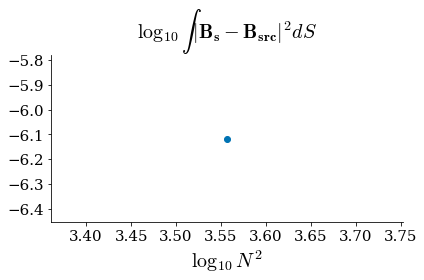

In [14]:
plot_xy(np.log10(b_chi), 
        np.log10( ( sMv * 2 + 0) * ( sNv * 2 + 0 ) ), # grid to plot on
        ''r'$\log_{10} \int | \mathbf{B_s - B_{src}} | ^2 dS$', # title for the figure
        ''r'$\log_{10} N^2 $', # title of x axis
       )

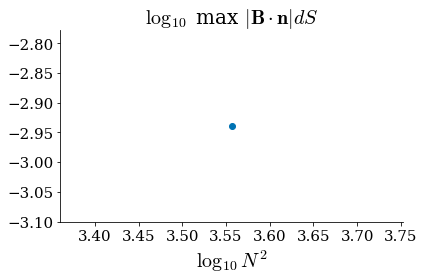

In [15]:
plot_xy(np.log10(Bn_chi), 
        np.log10( ( sMv * 2 + 0) * ( sNv * 2 + 0 ) ), # grid to plot on
        ''r'$\log_{10} $ max $| \mathbf{B\cdot n} | dS$', # title for the figure
        ''r'$\log_{10} N^2 $', # title of x axis
       )

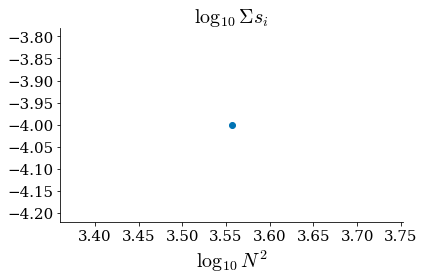

In [16]:
plot_xy(np.log10(abs(jnp.asarray(source_chi))), 
        np.log10(( sMv * 2 + 0 ) * ( sNv * 2 + 0 ) ), # grid to plot on
        ''r'$\log_{10} \Sigma s_i $', # title for the figure
        ''r'$\log_{10} N^2 $', # title of x axis
       )

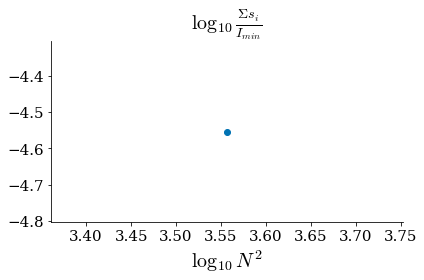

In [17]:
plot_xy(np.log10(abs(jnp.asarray(source_chi) * jnp.asarray(min_I) ** (-1))), 
        np.log10(( sMv * 2 + 0 ) * ( sNv * 2 + 0 ) ), # grid to plot on
        ''r'$\log_{10} \frac{\Sigma s_i}{I_{min}} $', # title for the figure
        ''r'$\log_{10} N^2 $', # title of x axis
       )

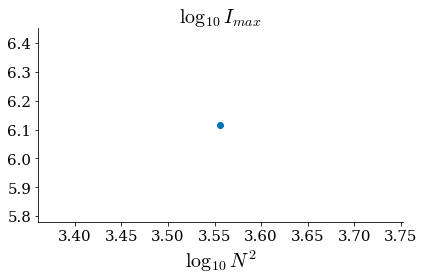

In [18]:
plot_xy(np.log10(abs(jnp.asarray(max_I))), 
        np.log10(( sMv * 2 + 0 ) * ( sNv * 2 + 0 ) ), # grid to plot on
        ''r'$\log_{10} I_{max} $', # title for the figure
        ''r'$\log_{10} N^2 $', # title of x axis
       )

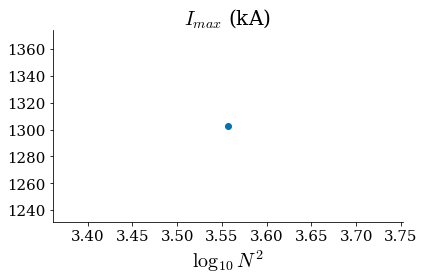

In [19]:
plot_xy(jnp.asarray(max_I) * 1e-3, 
        np.log10(( sMv * 2 + 0 ) * ( sNv * 2 + 0 ) ), # grid to plot on
        ''r'$ I_{max} $ (kA)', # title for the figure
        ''r'$\log_{10} N^2 $', # title of x axis
       )

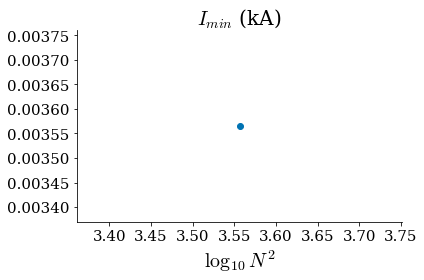

In [20]:
plot_xy(jnp.asarray(min_I) * 1e-3, 
        np.log10(( sMv * 2 + 0 ) * ( sNv * 2 + 0 ) ), # grid to plot on
        ''r'$ I_{min} $ (kA)', # title for the figure
        ''r'$\log_{10} N^2 $', # title of x axis
       )